# Duke Machine Learning Summer School: Generative AI

### Conditional GAN on MNIST

## 1. Imports and Device Setup

First, we import all the libraries we’ll need and set up our computation device (CPU vs. GPU).

- **torch**: The main PyTorch package for tensor operations.  
- **torch.nn** and **torch.optim**: For building neural network modules and choosing optimizers.  
- **torchvision.datasets** and **torchvision.transforms**: For loading and preprocessing MNIST images.  
- **torchvision.utils as vutils**: Utility functions (e.g., `make_grid`) for visualizing generated images.  
- **matplotlib.pyplot**: To display images and plots inline.

At the end, we check whether a CUDA‐enabled GPU is available, and set `device` accordingly.


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils as vutils
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## 2. Hyperparameters

Here we define all the key hyperparameters for training:

- `batch_size`: Number of MNIST images per mini‐batch.  
- `lr`: Base learning rate (we will use slightly different LR for G and D later).  
- `num_epochs`: Total number of passes over the entire dataset.  
- `nz`: Dimensionality of the random noise vector fed into the generator.  
- `num_classes`: Because MNIST has digits 0–9.  
- `embed_size`: Size of the one‐hot label embedding (equal to `num_classes`, but listed separately for clarity).  
- `gen_hidden` and `disc_hidden`: Hidden‐layer sizes for both Generator and Discriminator networks.

Tweaking these values will change convergence speed and sample quality.


In [9]:
batch_size = 128
lr = 3e-4
num_epochs = 30
nz = 150  # noise vector size
num_classes = 10  # digits 0–9
embed_size = 10  # one-hot embedding size
gen_hidden = 256
disc_hidden = 256

## 3. Data Loading and Preprocessing

We load the MNIST dataset and apply these transforms:

1. **`ToTensor()`**: Converts each PIL image (28×28 pixels) into a FloatTensor in [0, 1].  
2. **`Normalize((0.5,), (0.5,))`**: Shifts the range from [0, 1] to [–1, +1], which matches our Generator’s `tanh` outputs.

Then we build a PyTorch `DataLoader` that shuffles the training set in batches of size `batch_size`.


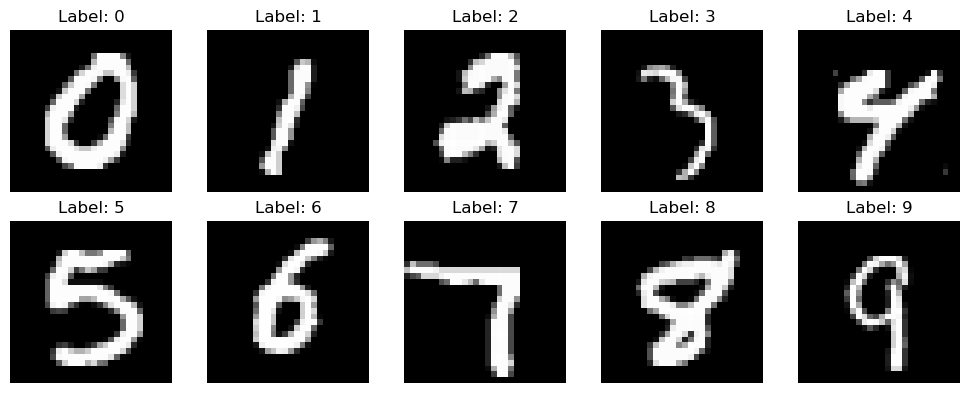

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(mnist, batch_size=batch_size, shuffle=True, num_workers=2)

# Collect one example per class (0–9)
examples = {}
for imgs, labels in loader:
    for img, lbl in zip(imgs, labels):
        label = lbl.item()
        if label not in examples:
            examples[label] = img
        if len(examples) == num_classes:
            break
    if len(examples) == num_classes:
        break

# Plot a 2×5 grid of one image per digit
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for digit in range(num_classes):
    ax = axs[digit // 5, digit % 5]
    # Unnormalize: originally normalized to [-1,1], so map back to [0,1]
    img = examples[digit].cpu() * 0.5 + 0.5  
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"Label: {digit}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## 4. Defining Generator and Discriminator

### 4.1 Generator (G)

- **Input**:  
  1. A random noise vector `noise` of size `(batch_size, nz)`.  
  2. A label vector `labels` of shape `(batch_size,)`, containing integer class IDs in {0,…,9}.

- **Label Conditioning**:  
  We convert each integer label into a one‐hot vector of length `num_classes`.  
  Then we concatenate the noise vector `(nz,)` with its corresponding one‐hot label `(num_classes,)`, producing a single input of size `(nz + num_classes)`.

- **Network Architecture**:  
  1. **Linear(nz + num_classes → 512)** → BatchNorm1d(512) → ReLU  
  2. **Linear(512 → 512)** → BatchNorm1d(512) → ReLU  
  3. **Linear(512 → 28×28)** → Tanh  
  4. **Reshape** from `(batch_size, 28*28)` to `(batch_size, 1, 28, 28)` to form a grayscale image in [–1,1].

### 4.2 Discriminator (D)

- **Input**:  
  1. A real or fake image `imgs` of shape `(batch_size, 1, 28, 28)`.  
  2. A label vector `labels` of shape `(batch_size,)`, same as above.

- **Label Conditioning**:  
  We flatten the image to size `28*28 = 784`, convert the labels into one‐hot `(num_classes,)`, then concatenate to a vector of length `(784 + num_classes)`.

- **Network Architecture**:  
  1. **Linear(784 + num_classes → 512)** → LeakyReLU(0.2) → Dropout(0.3)  
  2. **Linear(512 → 512)** → LeakyReLU(0.2) → Dropout(0.3)  
  3. **Linear(512 → 1)** → Sigmoid (produces a probability “real vs. fake”).

Below is the PyTorch implementation of both networks.


In [11]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(nz + num_classes, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),

            nn.Linear(512, 28*28),
            nn.Tanh()
        )
    def forward(self, noise, labels):
        one_hot = torch.zeros(noise.size(0), num_classes, device=noise.device)
        one_hot.scatter_(1, labels.unsqueeze(1), 1)
        x = torch.cat([noise, one_hot], dim=1)
        return self.net(x).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28 + num_classes, 512),
            nn.LeakyReLU(0.2, True),
            nn.Dropout(0.3),

            nn.Linear(512, 512),
            nn.LeakyReLU(0.2, True),
            nn.Dropout(0.3),

            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    def forward(self, imgs, labels):
        img_flat = imgs.view(imgs.size(0), -1)
        one_hot = torch.zeros(imgs.size(0), num_classes, device=imgs.device)
        one_hot.scatter_(1, labels.unsqueeze(1), 1)
        x = torch.cat([img_flat, one_hot], dim=1)
        return self.net(x)

## 5. Initialize Networks, Loss, and Optimizers

1. **Instantiate** the Generator and Discriminator, then move both to `device` (GPU if available).  
2. **Loss Function**: We use Binary Cross‐Entropy (`nn.BCELoss`) for both G and D.  
   - Discriminator wants to output 1 for real images, 0 for fake.  
   - Generator wants D(fake) to approach 1 (i.e., fool the discriminator).  
3. **Optimizers**:  
   - We use Adam with different learning rates (`lr_G = 1e-4`, `betas=(0.0, 0.9)`) for the generator.  
   - For D, we use a slightly higher learning rate (`lr_D = 4e-4`, `betas=(0.5, 0.9)`).  
   - The `betas` values follow best practices in GAN training to stabilize convergence.


In [12]:
netG = Generator().to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()
optG = optim.Adam(netG.parameters(), lr=lr, betas=(0.0, 0.9))
optD = optim.Adam(netD.parameters(), lr=4*lr, betas=(0.5, 0.9))

## 6. Fixed Noise & Label Vectors for Demo Outputs

To monitor training progress, we’ll generate a fixed set of examples (0–9) at the end of each epoch.  
- `fixed_noise`: A tensor of shape `(num_classes, nz)` drawn from a standard normal distribution (so each row is a latent vector).  
- `fixed_labels`: A tensor `[0,1,2,…,9]` of length `num_classes`.  

At the end of each epoch, we feed `(fixed_noise, fixed_labels)` through the generator so that we always visualize the same 10 latent vectors, but conditioned on each digit class (0–9). This makes it easy to see improvement over time.


In [13]:
fixed_noise = torch.randn(num_classes, nz, device=device)
fixed_labels = torch.arange(0, num_classes, dtype=torch.long, device=device)

## 7. Training Loop

Below is the standard adversarial training loop. Each epoch consists of:

1. **Discriminator Update** (for each mini‐batch):  
   - **Real Step**:  
     - Sample a batch of real images (`real_imgs`) and their labels (`real_labels`).  
     - Compute `out_real = D(real_imgs, real_labels)` → expect it close to 1.  
     - Compute `loss_real = BCE(out_real, real_target)` where `real_target = torch.ones(bs,1)`.  
   - **Fake Step**:  
     - Sample random noise `noise` of shape `(bs, nz)`.  
     - Sample random labels `fake_labels` of shape `(bs,)`.  
     - Generate `fake_imgs = G(noise, fake_labels)`.  
     - Compute `out_fake = D(fake_imgs.detach(), fake_labels)` → expect it close to 0.  
     - Compute `loss_fake = BCE(out_fake, fake_target)` where `fake_target = torch.zeros(bs,1)`.  
   - **Total D Loss**: `lossD = loss_real + loss_fake`; backpropagate `lossD` and update `netD`.

2. **Generator Update** (after D step):  
   - Generate a fresh batch of fake images: `fake_imgs = G(noise, fake_labels)` (you can reuse `noise` and `fake_labels` or sample new ones).  
   - Compute `out_gen = D(fake_imgs, fake_labels)` → we want D to think these are real.  
   - Compute `lossG = BCE(out_gen, gen_target)` where `gen_target = torch.ones(bs,1)`.  
   - Backpropagate `lossG` and update `netG`.

3. **Logging & Visualization**:  
   - Print `lossD` and `lossG` at the end of each epoch.  
   - Use `(fixed_noise, fixed_labels)` to generate a 0–9 grid and display with `matplotlib.pyplot`.

This alternating update (D first, then G) is the essence of GAN training.


Epoch 1/30  Loss_D: 1.7062  Loss_G: 2.0004


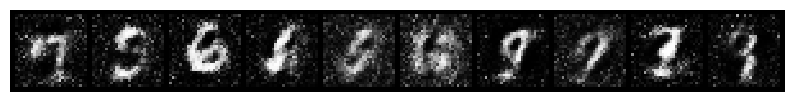

Epoch 2/30  Loss_D: 0.9683  Loss_G: 3.0537


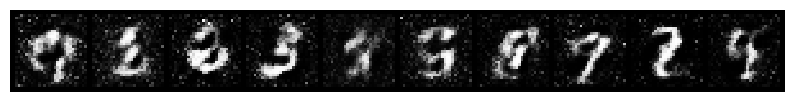

Epoch 3/30  Loss_D: 0.9442  Loss_G: 1.4522


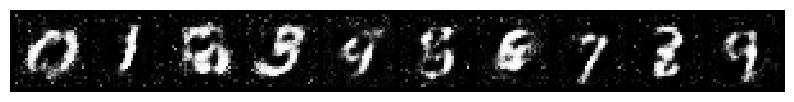

Epoch 4/30  Loss_D: 1.0748  Loss_G: 2.1951


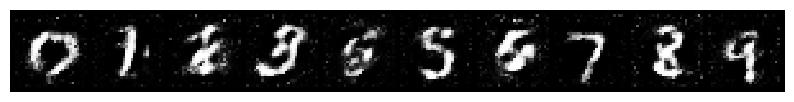

Epoch 5/30  Loss_D: 1.0951  Loss_G: 1.0633


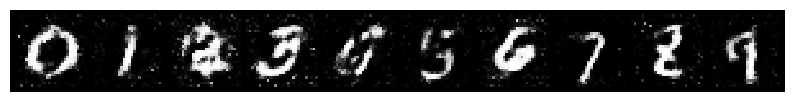

Epoch 6/30  Loss_D: 0.9584  Loss_G: 1.2044


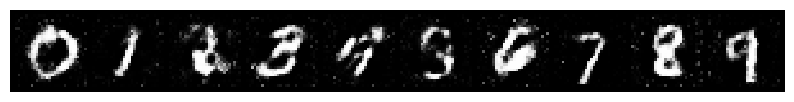

Epoch 7/30  Loss_D: 1.0945  Loss_G: 1.3522


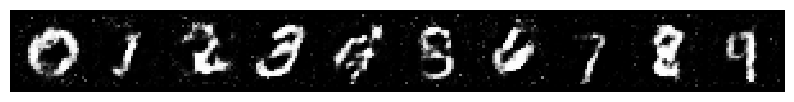

Epoch 8/30  Loss_D: 1.2120  Loss_G: 1.4861


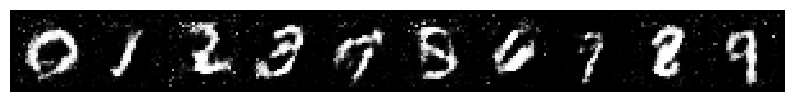

Epoch 9/30  Loss_D: 1.1486  Loss_G: 1.0048


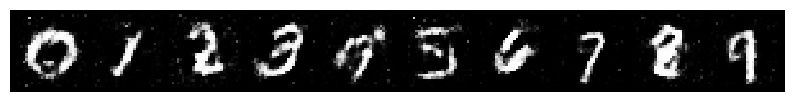

Epoch 10/30  Loss_D: 1.2095  Loss_G: 1.2257


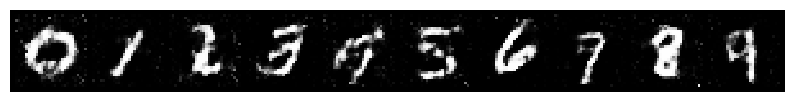

Epoch 11/30  Loss_D: 1.2843  Loss_G: 0.9213


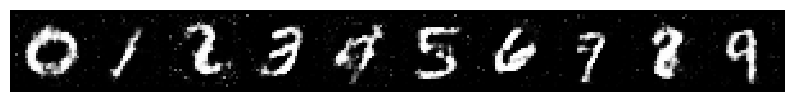

Epoch 12/30  Loss_D: 1.3368  Loss_G: 1.0202


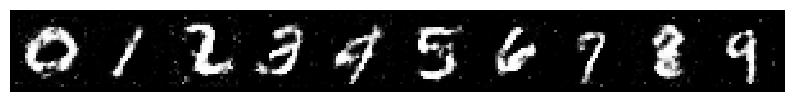

Epoch 13/30  Loss_D: 1.2153  Loss_G: 1.0264


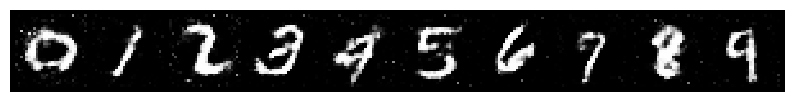

Epoch 14/30  Loss_D: 1.2770  Loss_G: 1.2391


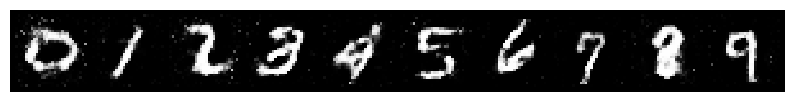

Epoch 15/30  Loss_D: 1.3086  Loss_G: 0.6623


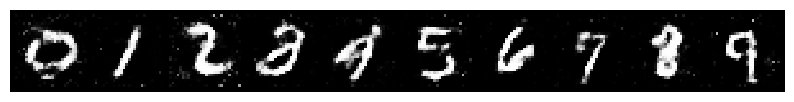

Epoch 16/30  Loss_D: 1.2388  Loss_G: 0.7652


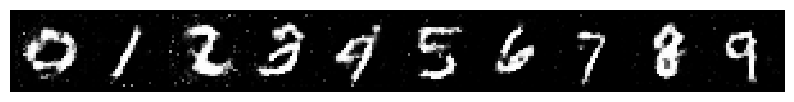

Epoch 17/30  Loss_D: 1.3212  Loss_G: 0.7175


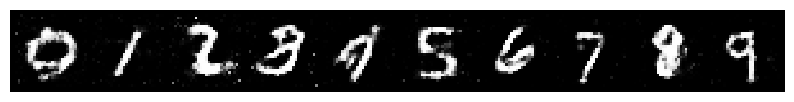

Epoch 18/30  Loss_D: 1.3455  Loss_G: 0.7812


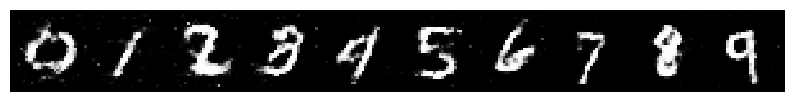

Epoch 19/30  Loss_D: 1.3189  Loss_G: 0.8142


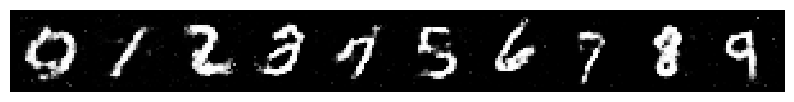

Epoch 20/30  Loss_D: 1.2928  Loss_G: 0.7818


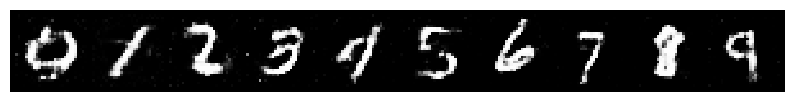

Epoch 21/30  Loss_D: 1.3716  Loss_G: 1.0446


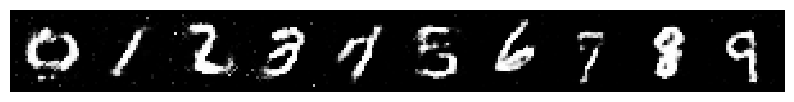

Epoch 22/30  Loss_D: 1.2859  Loss_G: 0.9325


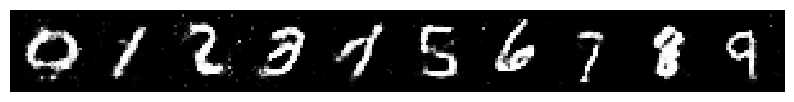

Epoch 23/30  Loss_D: 1.3017  Loss_G: 0.8909


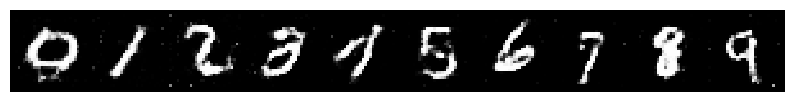

Epoch 24/30  Loss_D: 1.2958  Loss_G: 1.0590


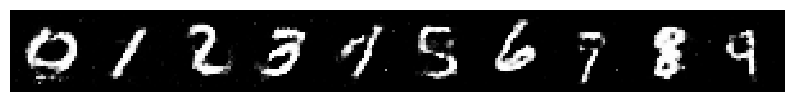

Epoch 25/30  Loss_D: 1.3304  Loss_G: 0.8699


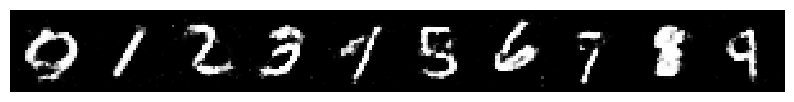

Epoch 26/30  Loss_D: 1.3541  Loss_G: 0.8340


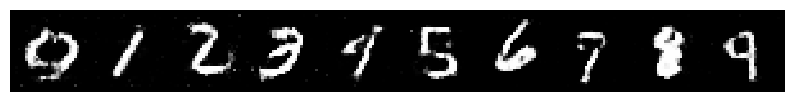

Epoch 27/30  Loss_D: 1.4463  Loss_G: 0.7503


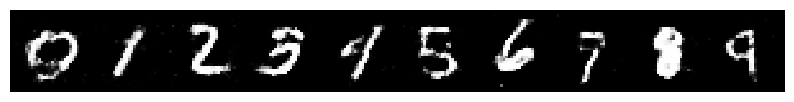

Epoch 28/30  Loss_D: 1.3521  Loss_G: 0.8186


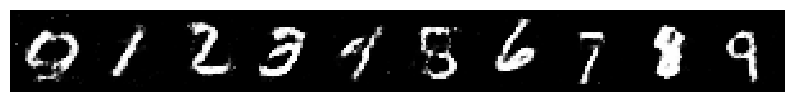

Epoch 29/30  Loss_D: 1.3855  Loss_G: 0.9132


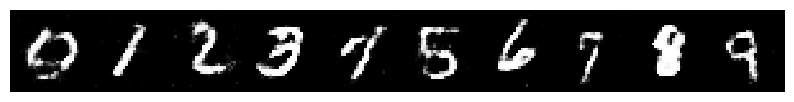

Epoch 30/30  Loss_D: 1.3837  Loss_G: 0.8478


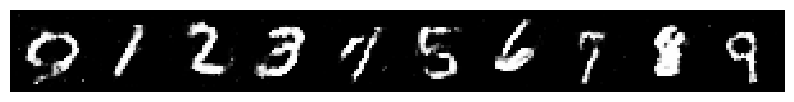

In [14]:
for epoch in range(1, num_epochs+1):
    for real_imgs, real_labels in loader:
        bs = real_imgs.size(0)
        real_imgs, real_labels = real_imgs.to(device), real_labels.to(device)

        # Train Discriminator
        netD.zero_grad()
        real_target = torch.ones(bs, 1, device=device)
        out_real = netD(real_imgs, real_labels)
        loss_real = criterion(out_real, real_target)

        noise = torch.randn(bs, nz, device=device)
        fake_labels = torch.randint(0, num_classes, (bs,), device=device)
        fake_imgs = netG(noise, fake_labels)
        fake_target = torch.zeros(bs, 1, device=device)
        out_fake = netD(fake_imgs.detach(), fake_labels)
        loss_fake = criterion(out_fake, fake_target)

        lossD = loss_real + loss_fake
        lossD.backward()
        optD.step()

        # Train Generator
        netG.zero_grad()
        gen_target = torch.ones(bs, 1, device=device)
        out_gen = netD(fake_imgs, fake_labels)
        lossG = criterion(out_gen, gen_target)
        lossG.backward()
        optG.step()

    print(f"Epoch {epoch}/{num_epochs}  Loss_D: {lossD.item():.4f}  Loss_G: {lossG.item():.4f}")

    # Generate and display 0-9 samples
    with torch.no_grad():
        gen_imgs = netG(fixed_noise, fixed_labels)
        grid = vutils.make_grid(gen_imgs, nrow=num_classes, normalize=True, value_range=(-1,1))
        plt.figure(figsize=(10,2))
        plt.axis('off')
        plt.imshow(grid.permute(1,2,0).cpu(), interpolation='nearest')
        plt.show()

## 8. Save Generator Checkpoint

Finally, if you wish to use the trained generator later, you can save its weights:


In [15]:
# Save the final generator state
torch.save(netG.state_dict(), "cgan_mnist_generator.pth")

## 9. Load Saved Generator and Generate New Samples

Now that we have saved our trained Generator’s weights, let’s load them into a fresh model, generate new noise vectors, and produce 5 samples per digit class (0–9).


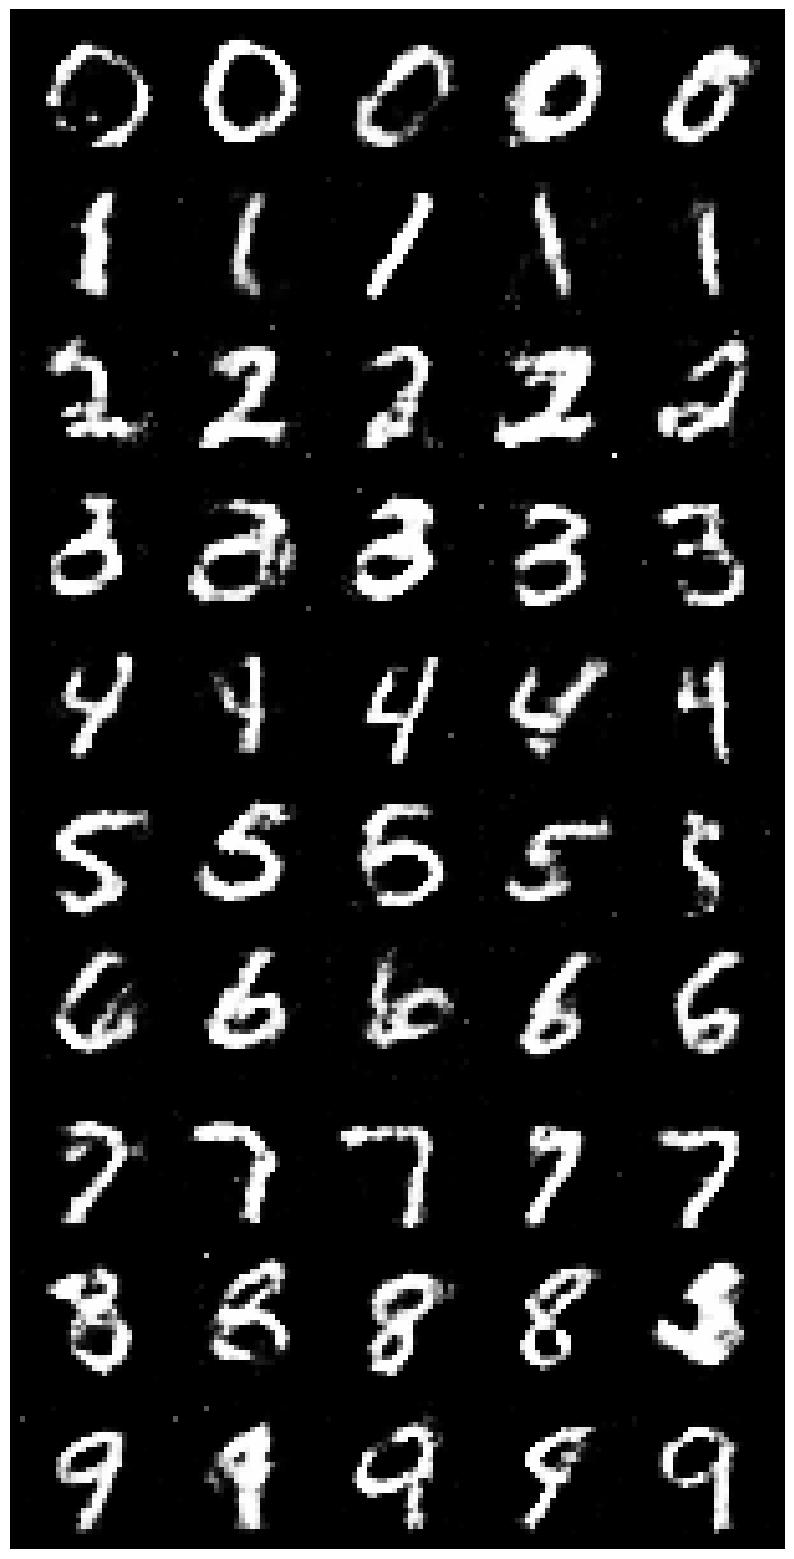

In [17]:
# 1. Instantiate a fresh Generator and load saved weights
netG2 = Generator().to(device)
netG2.load_state_dict(torch.load("cgan_mnist_generator.pth", map_location=device))
netG2.eval()

# 2. Define how many samples per class to generate
num_per_class = 5  # number of generated images for each digit label

# 3. Create a labels tensor: [0,0,0,0,0, 1,1,1,1,1, 2,2,2,2,2, ..., 9,9,9,9,9]
labels_list = torch.arange(num_classes, device=device).unsqueeze(1).repeat(1, num_per_class).view(-1)

# 4. Draw random noise of shape (num_classes * num_per_class, nz)
noise = torch.randn(num_classes * num_per_class, nz, device=device)

# 5. Generate fake images with the loaded generator
with torch.no_grad():
    generated_imgs = netG2(noise, labels_list)  # shape: (10*5, 1, 28, 28)

# 6. Make a grid: 5 images per row, 10 rows (one row per label)
grid = vutils.make_grid(generated_imgs, nrow=num_per_class, normalize=True, value_range=(-1, 1))

# 7. Display the grid
plt.figure(figsize=(num_per_class*2, num_classes*2))
plt.axis('off')
plt.imshow(grid.permute(1, 2, 0).cpu(), interpolation='nearest')
plt.show()
